In [4]:
# Подключаем Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

ModuleNotFoundError: ignored

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
%cd /home/fff/"Рабочий стол"/projekt/aii

/home/fff/Рабочий стол/projekt/aii


In [11]:
# Загружаем датасет из файла в pandas
df = pd.read_csv('t1_20220101_20220726_rg_201589066.csv', index_col=0)

/home/fff/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3221: DtypeWarning: Columns (12,39,51,52) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [12]:
# Проверяем, что датасет нормально загрузился в переменную df
df.head(5)

,Unnamed: 0.1,ym:s:bounce,ym:s:browser,ym:s:browserCountry,ym:s:browserLanguage,ym:s:clientID,ym:s:cookieEnabled,ym:s:date,ym:s:deviceCategory,ym:s:endURL,...,ym:s:screenWidth,ym:s:startURL,ym:s:UTMCampaign,ym:s:UTMContent,ym:s:UTMMedium,ym:s:UTMSource,ym:s:UTMTerm,ym:s:visitDuration,ym:s:visitID,ym:s:watchIDs
0,0,1,chrome,us,en,1654489350380812167,1,2022-06-06,1,endURL_1,...,1920,startURL_1,NaN,NaN,NaN,NaN,NaN,0,3107078458710949968,[3107078458710949968]
1,1,1,yandexsearch,ru,ru,1654774521346384154,1,2022-06-09,2,endURL_2,...,360,startURL_2,june22,spec_all,banner,novostroy-m,NaN,0,3181830630067929292,[3181830630067929292]
2,2,1,safari_mobile,NaN,ru,1656147792622821132,1,2022-06-25,2,endURL_1,...,375,startURL_1,june22,spec_all,banner,pronovostroy,NaN,0,3541825601891205395,[3541825601891205395]
3,3,0,chromemobile,ru,ru,164793238281186116,1,2022-03-22,2,endURL_3,...,360,startURL_1,konkurenty-vc_net_mmo|61228084,id|31333861543_|cid|61228084|gid|4546929028|ai...,cpc,yandex,31333861543_,63,1387990388022968378,"[1387990388022968378,1388007054027522266,13879..."
4,4,1,safari_mobile,NaN,ru,1654789614786669323,1,2022-06-09,2,endURL_1,...,390,startURL_1,prigranichye_net_mir|74741535,id|39038979686_|cid|74741535|gid|4924248374|ai...,cpc,yandex,39038979686_,0,3185787202690875607,[3185787202690875607]


In [13]:
# Создаем копию датасета
data_backup = df.copy()

In [14]:
# Удаляем столбцы, которые либо совсем пустые, либо имеют значений меньше 20
# т.к. они не несут никакой пользы для достижения целевого таргета и будут наоборот мешать модели отрабатывать правильно
df.drop('ym:s:from', axis=1, inplace=True)
df.drop('ym:s:lastSocialNetworkProfile', axis=1, inplace=True)
df.drop('ym:s:openstatAd', axis=1, inplace=True)
df.drop('ym:s:openstatCampaign', axis=1, inplace=True)
df.drop('ym:s:openstatService', axis=1, inplace=True)
df.drop('ym:s:openstatSource', axis=1, inplace=True)
df.drop('ym:s:impressionsProductCoupon', axis=1, inplace=True)

In [15]:
# Удаляем из ip адреса все, кроме числовых значений
df['ym:s:ipAddress'] = df['ym:s:ipAddress'].str.replace(r'\D+', '')
# Приведем ip адреса к целочисленным значениям
df['ym:s:ipAddress'] = df['ym:s:ipAddress'].astype(int)

In [16]:
# Заполняем NaN значения в столбце средними значениями по столбцу
df['ym:s:lastDirectClickOrder'] = df['ym:s:lastDirectClickOrder'].fillna(df['ym:s:lastDirectClickOrder'].mean())
# Приведем значения столбца к типу float
df['ym:s:lastDirectClickOrder'] = df['ym:s:lastDirectClickOrder'].astype(float)
df['ym:s:visitID'] = df['ym:s:visitID'].astype(float)

In [17]:
# Изменим тип столбца с uint64 на int64
df['ym:s:clientID'] = df['ym:s:clientID'].astype(int)

In [18]:
# Создаем LabelEncoder
le = LabelEncoder()

columns = ['ym:s:browser', 'ym:s:browserCountry', 'ym:s:browserLanguage', 'ym:s:date', 'ym:s:endURL', 'ym:s:firstGCLID',
           'ym:s:goalsDateTime', 'ym:s:goalsPrice', 'ym:s:goalsSerialNumber', 'ym:s:lastAdvEngine', 'ym:s:lastClickBannerGroupName',
           'ym:s:lastDirectClickBannerName', 'ym:s:lastDirectClickOrderName', 'ym:s:lastDirectConditionType',
           'ym:s:lastDirectPhraseOrCond', 'ym:s:lastDirectPlatform', 'ym:s:lastDirectPlatformType', 'ym:s:lastGCLID',
           'ym:s:lastReferalSource', 'ym:s:lastSearchEngine', 'ym:s:lastSearchEngineRoot', 'ym:s:lastSignificantGCLID',
           'ym:s:lastSocialNetwork', 'ym:s:lastTrafficSource', 'ym:s:mobilePhone', 'ym:s:networkType',
           'ym:s:offlineCallFirstTimeCaller', 'ym:s:offlineCallHoldDuration', 'ym:s:offlineCallMissed', 'ym:s:offlineCallTag',
           'ym:s:offlineCallTalkDuration', 'ym:s:offlineCallURL', 'ym:s:referer', 'ym:s:regionCity', 'ym:s:startURL',
           'ym:s:UTMCampaign', 'ym:s:UTMContent', 'ym:s:UTMMedium', 'ym:s:UTMSource', 'ym:s:UTMTerm', 'ym:s:watchIDs',
           'ym:s:goalsID']
           
# Переводим все столбцы в числовые значения циклом
for column in columns:
    df[column] = le.fit_transform(df[column])

In [ ]:
# Переводим все столбцы в числовые значения
#df['ym:s:browser'] = le.fit_transform(df['ym:s:browser'])
#df['ym:s:browserCountry'] = le.fit_transform(df['ym:s:browserCountry'])
#df['ym:s:browserLanguage'] = le.fit_transform(df['ym:s:browserLanguage'])
#df['ym:s:date'] = le.fit_transform(df['ym:s:date'])
#df['ym:s:endURL'] = le.fit_transform(df['ym:s:endURL'])
#df['ym:s:firstGCLID'] = le.fit_transform(df['ym:s:firstGCLID'])
#df['ym:s:goalsDateTime'] = le.fit_transform(df['ym:s:goalsDateTime'])
#df['ym:s:goalsPrice'] = le.fit_transform(df['ym:s:goalsPrice'])
#df['ym:s:goalsSerialNumber'] = le.fit_transform(df['ym:s:goalsSerialNumber'])
#df['ym:s:lastAdvEngine'] = le.fit_transform(df['ym:s:lastAdvEngine'])
#df['ym:s:lastClickBannerGroupName'] = le.fit_transform(df['ym:s:lastClickBannerGroupName'])
#df['ym:s:lastDirectClickBannerName'] = le.fit_transform(df['ym:s:lastDirectClickBannerName'])
#df['ym:s:lastDirectClickOrderName'] = le.fit_transform(df['ym:s:lastDirectClickOrderName'])
#df['ym:s:lastDirectConditionType'] = le.fit_transform(df['ym:s:lastDirectConditionType'])
#df['ym:s:lastDirectPhraseOrCond'] = le.fit_transform(df['ym:s:lastDirectPhraseOrCond'])
#df['ym:s:lastDirectPlatform'] = le.fit_transform(df['ym:s:lastDirectPlatform'])
#df['ym:s:goalsSerialNumber'] = le.fit_transform(df['ym:s:goalsSerialNumber'])
#df['ym:s:goalsSerialNumber'] = le.fit_transform(df['ym:s:goalsSerialNumber'])
#df['ym:s:lastDirectPlatformType'] = le.fit_transform(df['ym:s:lastDirectPlatformType'])
#df['ym:s:lastGCLID'] = le.fit_transform(df['ym:s:lastGCLID'])
#df['ym:s:lastReferalSource'] = le.fit_transform(df['ym:s:lastReferalSource'])
#df['ym:s:lastSearchEngine'] = le.fit_transform(df['ym:s:lastSearchEngine'])
#df['ym:s:lastSearchEngineRoot'] = le.fit_transform(df['ym:s:lastSearchEngineRoot'])
#df['ym:s:lastSignificantGCLID'] = le.fit_transform(df['ym:s:lastSignificantGCLID'])
#df['ym:s:lastSocialNetwork'] = le.fit_transform(df['ym:s:lastSocialNetwork'])
#df['ym:s:lastTrafficSource'] = le.fit_transform(df['ym:s:lastTrafficSource'])
#df['ym:s:mobilePhone'] = le.fit_transform(df['ym:s:mobilePhone'])
#df['ym:s:networkType'] = le.fit_transform(df['ym:s:networkType'])
#df['ym:s:offlineCallFirstTimeCaller'] = le.fit_transform(df['ym:s:offlineCallFirstTimeCaller'])
#df['ym:s:offlineCallHoldDuration'] = le.fit_transform(df['ym:s:offlineCallHoldDuration'])
#df['ym:s:offlineCallMissed'] = le.fit_transform(df['ym:s:offlineCallMissed'])
#df['ym:s:offlineCallTag'] = le.fit_transform(df['ym:s:offlineCallTag'])
#df['ym:s:offlineCallTalkDuration'] = le.fit_transform(df['ym:s:offlineCallTalkDuration'])
#df['ym:s:offlineCallURL'] = le.fit_transform(df['ym:s:offlineCallURL'])
#df['ym:s:referer'] = le.fit_transform(df['ym:s:referer'])
#df['ym:s:regionCity'] = le.fit_transform(df['ym:s:regionCity'])
#df['ym:s:startURL'] = le.fit_transform(df['ym:s:startURL'])
#df['ym:s:UTMCampaign'] = le.fit_transform(df['ym:s:UTMCampaign'])
#df['ym:s:UTMContent'] = le.fit_transform(df['ym:s:UTMContent'])
#df['ym:s:UTMMedium'] = le.fit_transform(df['ym:s:UTMMedium'])
#df['ym:s:UTMSource'] = le.fit_transform(df['ym:s:UTMSource'])
#df['ym:s:UTMTerm'] = le.fit_transform(df['ym:s:UTMTerm'])
#df['ym:s:watchIDs'] = le.fit_transform(df['ym:s:watchIDs'])
#df['ym:s:goalsID'] = le.fit_transform(df['ym:s:goalsID'])

In [19]:
# Проверяем, что все столбцы преобразованы в числовые значения
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361919 entries, 0 to 361918
Data columns (total 60 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed: 0.1                     361919 non-null  int64  
 1   ym:s:bounce                      361919 non-null  int64  
 2   ym:s:browser                     361919 non-null  int64  
 3   ym:s:browserCountry              361919 non-null  int64  
 4   ym:s:browserLanguage             361919 non-null  int64  
 5   ym:s:clientID                    361919 non-null  int64  
 6   ym:s:cookieEnabled               361919 non-null  int64  
 7   ym:s:date                        361919 non-null  int64  
 8   ym:s:deviceCategory              361919 non-null  int64  
 9   ym:s:endURL                      361919 non-null  int64  
 10  ym:s:firstGCLID                  361919 non-null  int64  
 11  ym:s:goalsDateTime               361919 non-null  int64  
 12  ym

In [20]:
# Переносим целевой столбец на первый столбец
y = df['ym:s:goalsID'].copy()
df.drop('ym:s:goalsID',  axis=1, inplace=True)
df.insert(0,'ym:s:goalsID', y)

In [21]:
# Проверяем, что столбец ym:s:goalsID теперь стоит первым в датасете
df.head(5)

,ym:s:goalsID,Unnamed: 0.1,ym:s:bounce,ym:s:browser,ym:s:browserCountry,ym:s:browserLanguage,ym:s:clientID,ym:s:cookieEnabled,ym:s:date,ym:s:deviceCategory,...,ym:s:screenWidth,ym:s:startURL,ym:s:UTMCampaign,ym:s:UTMContent,ym:s:UTMMedium,ym:s:UTMSource,ym:s:UTMTerm,ym:s:visitDuration,ym:s:visitID,ym:s:watchIDs
0,2348,0,1,5,79,9,1654489350380812167,1,156,1,...,1920,1,360,77047,22,89,8203,0,3.107078e+18,237431
1,2348,1,1,48,63,37,1654774521346384154,1,159,2,...,360,7496,216,76950,2,52,8203,0,3.181831e+18,243337
2,2348,2,1,36,85,37,1656147792622821132,1,175,2,...,375,1,216,76950,2,59,8203,0,3.541826e+18,272694
3,2094,3,0,6,63,37,164793238281186116,1,80,2,...,360,1,226,32548,7,79,1799,63,1.387990e+18,30784
4,2348,4,1,36,85,37,1654789614786669323,1,159,2,...,390,1,281,66691,7,79,4530,0,3.185787e+18,244153


In [22]:
# Назначаем X и y
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [23]:
# Нормализуем данные
scaler = StandardScaler(with_mean=False)
scaler.fit(X)
X_scaled = scaler.transform(X)

In [24]:
# Посмотрим на нормализованные данные
print(X_scaled)

[[0.00000000e+00 2.31749755e+00 3.01650439e-01 ... 0.00000000e+00
  5.99960909e-01 2.27256682e+00]
 [4.77693199e-05 2.31749755e+00 2.89584421e+00 ... 0.00000000e+00
  6.14395169e-01 2.32909600e+00]
 [9.55386398e-05 2.31749755e+00 2.17188316e+00 ... 0.00000000e+00
  6.83908351e-01 2.61008603e+00]
 ...
 [3.36596959e+00 2.31749755e+00 3.61980526e-01 ... 2.28876180e-02
  8.03620120e-02 2.96323547e+00]
 [3.36601736e+00 0.00000000e+00 1.38759202e+00 ... 4.29142837e-02
  5.04993350e-01 1.87434526e+00]
 [3.36606513e+00 0.00000000e+00 3.01650439e-01 ... 4.29142837e-02
  2.25050032e-01 9.92849949e-02]]


In [25]:
# Применим SelectKBest для извлечения лучших признаков
model = SelectKBest(score_func=f_regression, k=50)
fit = model.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
# Соединяем два датафрейма для лучше визуализации 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  # названия столбцов нового датафрейма
print(featureScores.nlargest(50,'Score'))  # печатаем лучшие признаки

                              Specs          Score
41              ym:s:offlineCallTag  614265.757781
42     ym:s:offlineCallTalkDuration  613451.562525
39     ym:s:offlineCallHoldDuration  611203.616785
43              ym:s:offlineCallURL  586897.469319
40           ym:s:offlineCallMissed  546410.695753
38  ym:s:offlineCallFirstTimeCaller  541841.194757
12                  ym:s:goalsPrice  416468.062172
13           ym:s:goalsSerialNumber  168485.073403
11               ym:s:goalsDateTime   87517.154540
44                   ym:s:pageViews   76233.213833
56               ym:s:visitDuration   59414.151915
9                       ym:s:endURL   46736.740395
1                       ym:s:bounce   26448.898503
32        ym:s:lastSearchEngineRoot   15939.226873
31            ym:s:lastSearchEngine   15832.239850
27          ym:s:lastDirectPlatform   14560.804194
19    ym:s:lastClickBannerGroupName   13901.028438
55                     ym:s:UTMTerm   12135.809008
28      ym:s:lastDirectPlatform

In [26]:
# Ошибка возникает, потому что метод reshape не является методом объекта Pandas Series. 
#Вы можете использовать метод values для преобразования Pandas Series в массив numpy,
#а затем использовать метод reshape для изменения формы массива. 

#z = np.array(y)
#z = y.reshape(-1,1)
#print(z.shape)

#scaler.fit(z)
#z_scaled = scaler.transform(z)


AttributeError: ignored

In [27]:
z = y.values.reshape(-1,1)
print(z.shape)

scaler.fit(z)
z_scaled = scaler.transform(z)

(361919, 1)


In [28]:
# Применим SelectKBest для извлечения лучших признаков на нормализованных данных
model = SelectKBest(score_func=f_regression, k=50)
fit = model.fit(X_scaled,z_scaled)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
# Соединяем два датафрейма для лучше визуализации 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  # названия столбцов нового датафрейма
print(featureScores.nlargest(50,'Score'))  # печатаем лучшие признаки

                              Specs          Score
41              ym:s:offlineCallTag  614265.757661
42     ym:s:offlineCallTalkDuration  613451.562546
39     ym:s:offlineCallHoldDuration  611203.616855
43              ym:s:offlineCallURL  586897.469250
40           ym:s:offlineCallMissed  546410.695761
38  ym:s:offlineCallFirstTimeCaller  541841.194657
12                  ym:s:goalsPrice  416468.060350
13           ym:s:goalsSerialNumber  168485.073417
11               ym:s:goalsDateTime   87517.154542
44                   ym:s:pageViews   76233.213833
56               ym:s:visitDuration   59414.151915
9                       ym:s:endURL   46736.740395
1                       ym:s:bounce   26448.898503
32        ym:s:lastSearchEngineRoot   15939.226876
31            ym:s:lastSearchEngine   15832.239851
27          ym:s:lastDirectPlatform   14560.804194
19    ym:s:lastClickBannerGroupName   13901.028438
55                     ym:s:UTMTerm   12135.809007
28      ym:s:lastDirectPlatform

/home/fff/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


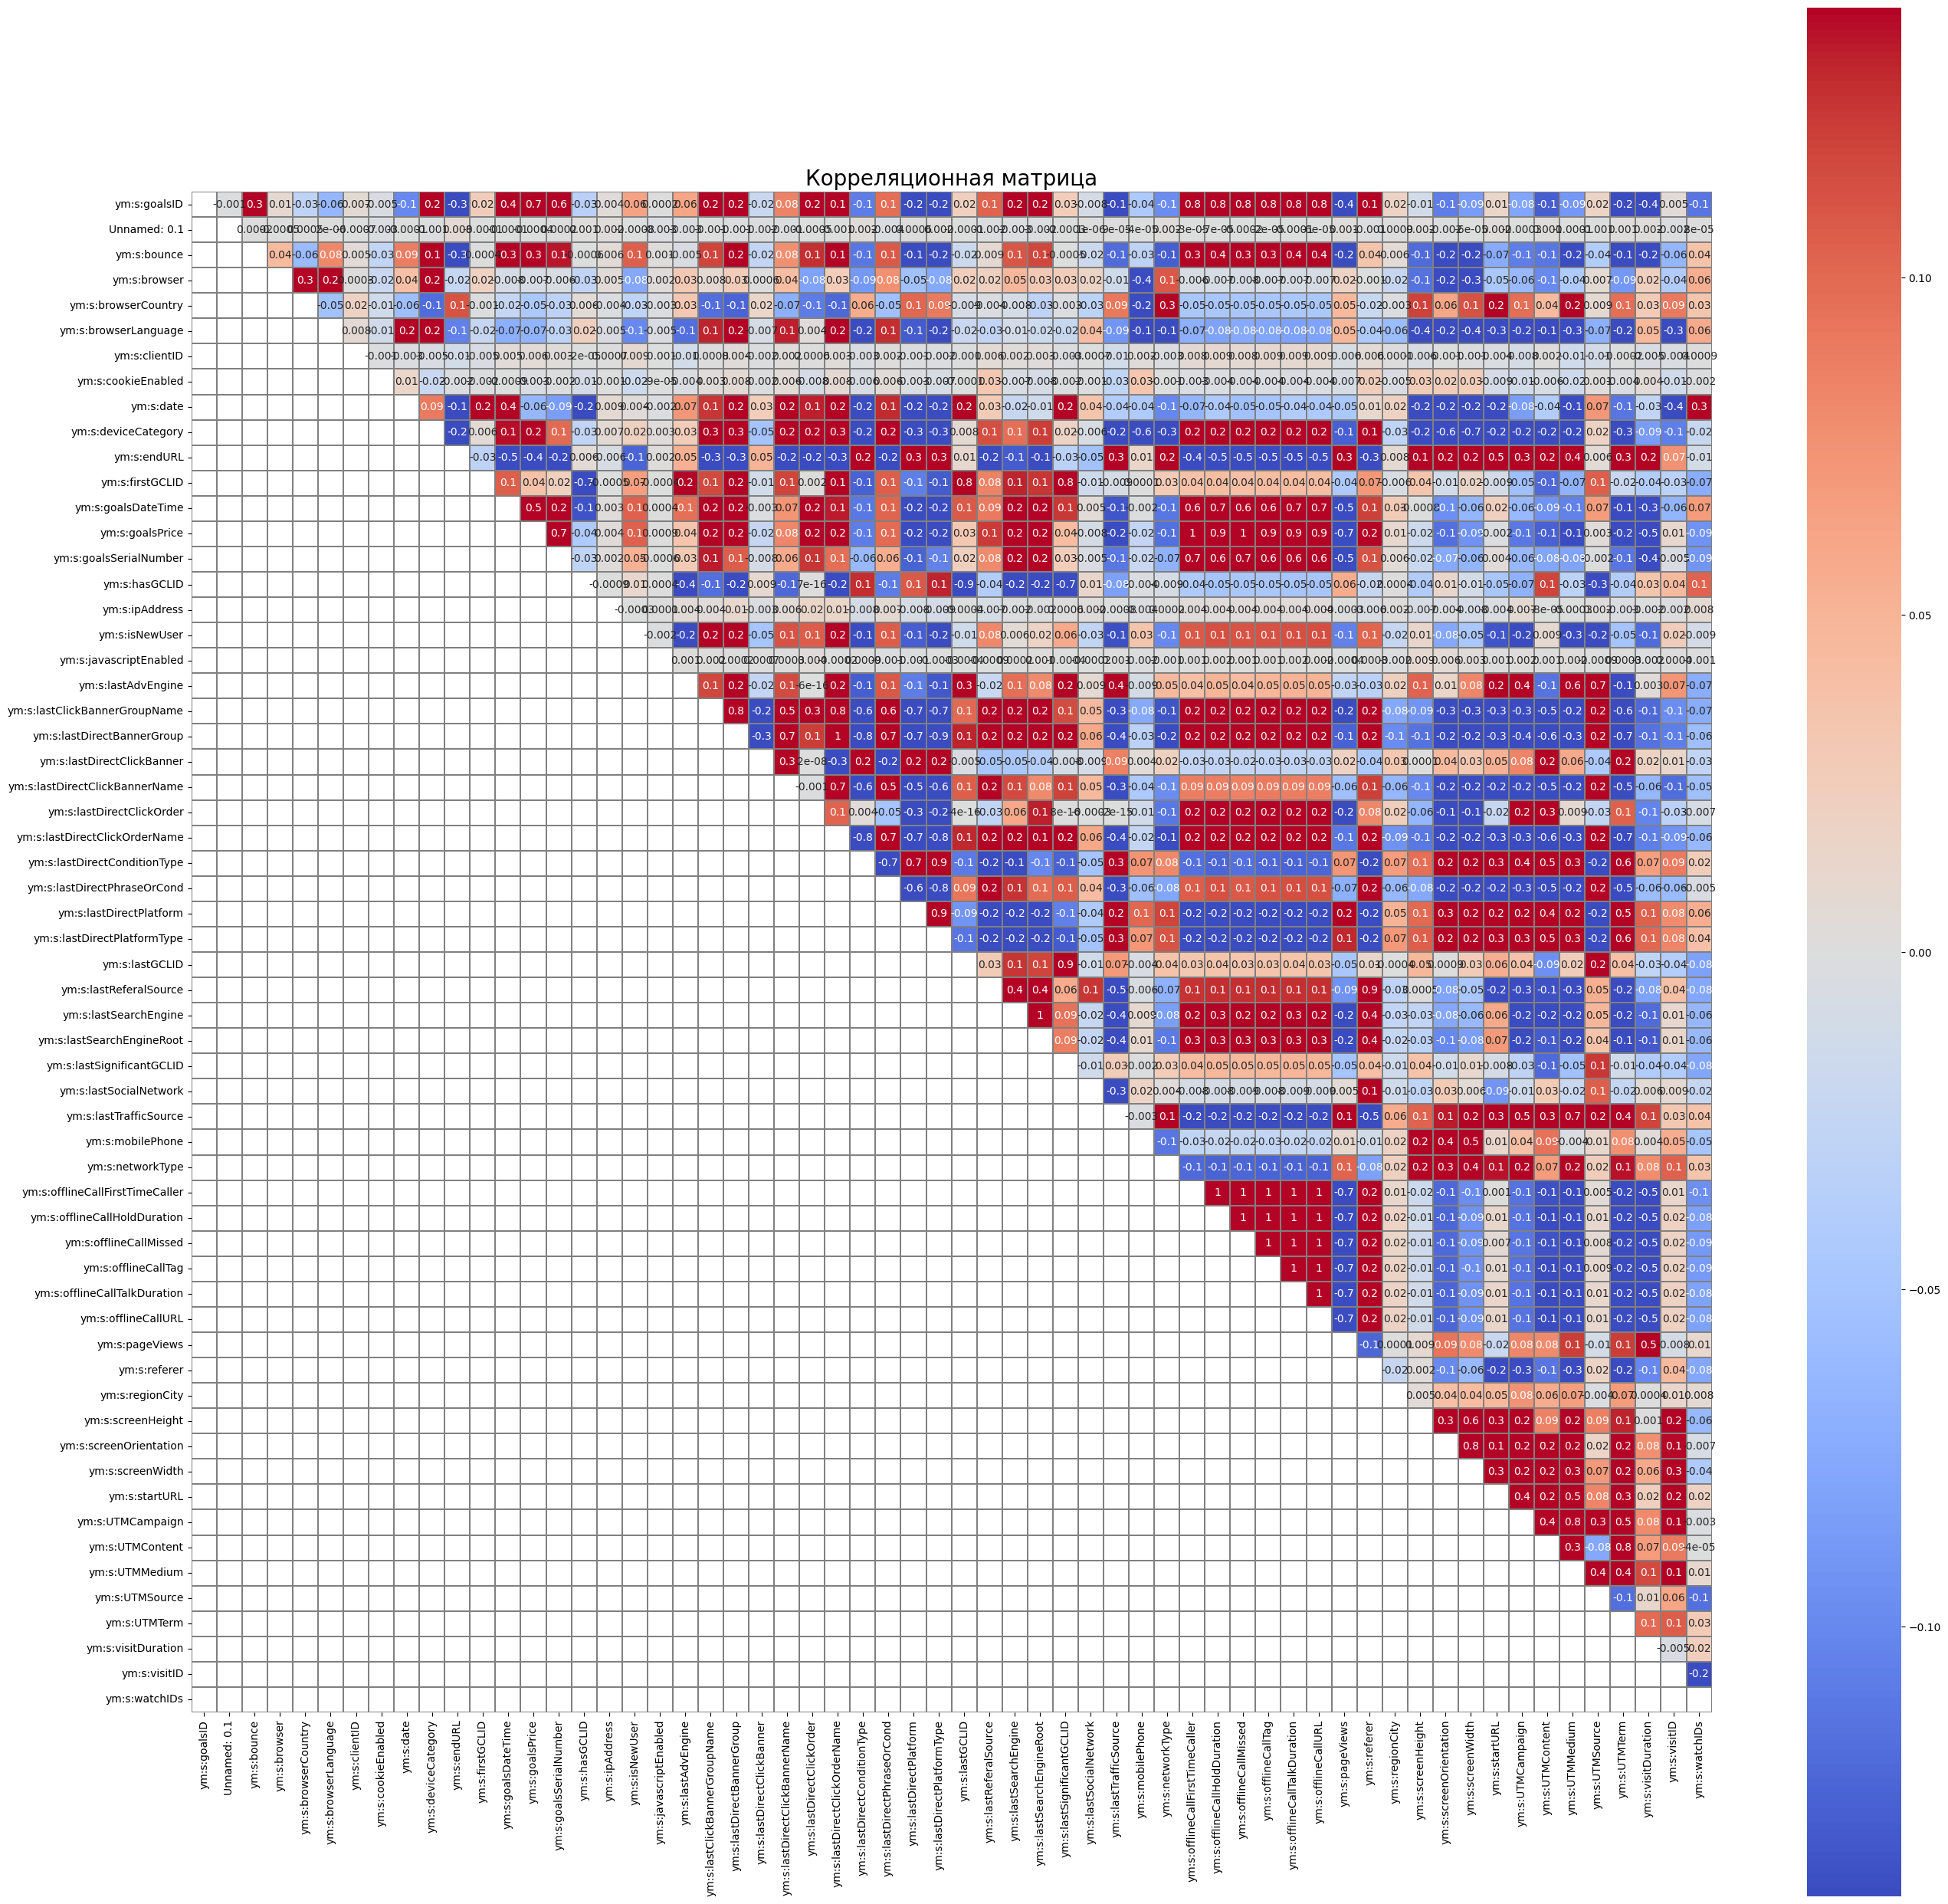

In [29]:
# Таблица корреляции признаков
mask_1 = np.tril(df.corr())
plt.figure(figsize=(32,32))
sb.heatmap(df.corr(), cmap='coolwarm', vmin=-0.14, vmax=0.14, center= 0, square=True, annot=True, fmt='.1g', linewidths =0.05, linecolor= 'gray', mask = mask_1)
plt.title("Корреляционная матрица", fontsize=20)
plt.show()